## Solving $A\lvert x \rangle = \lvert b \rangle$ using QSVT

Let's define a toy problem we would implement in Qiskit. We consider solving $A\lvert x \rangle = \lvert b \rangle$ where

$$A = c_0 A_0 + c_1 A_1$$ where $A_0 = X \otimes X,$  
$A_1 = Z \otimes Z$ and $c_0, c_1 \ge 0$. Also,


$$ \lvert b \rangle = H^{\otimes 2} \lvert 00 \rangle$$. We also strictly enforce that A is a Hemitian matrix.

### Block-encoding of A

We introduce $\zeta$, so that 
$cos(\zeta) = \frac{\sqrt{c_0}}{\sqrt{c_0 + c_1}}$ and $sin(\zeta) = \frac{\sqrt{c_1}}{\sqrt{c_0 + c_1}}$. 
The circuit shown below can block-encode A. 

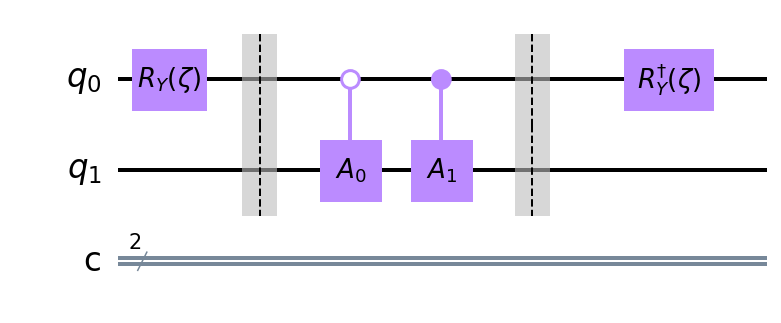

In [2]:
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.optimization.algorithms import GroverOptimizer, MinimumEigenOptimizer, GroverOptimizationResult
from qiskit.optimization.problems import QuadraticProgram
from docplex.mp.model import Model
from qiskit.circuit.library import QuadraticForm
from qiskit.aqua.algorithms.amplitude_amplifiers.grover import Grover
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit import IBMQ, BasicAer ,Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.optimization.converters.quadratic_program_to_qubo import (QuadraticProgramToQubo,
                                                    QuadraticProgramConverter)
from qiskit.optimization.algorithms import (OptimizationResultStatus, OptimizationAlgorithm,
                                     OptimizationResult)
import math as math
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Union, List
from copy import deepcopy
from qiskit.circuit import ParameterVector, Parameter
from collections import defaultdict
from scipy.optimize import minimize
from qiskit.quantum_info.states import partial_trace
from qiskit import QuantumCircuit, QuantumRegister



def named_circ(name, control=True):
    qc1 = QuantumCircuit(1, name=name)
    qc1.x(0) #dummy gate
    if control:
        named_circ = qc1.to_gate().control(1, ctrl_state='1')
    else:
        named_circ = qc1.to_gate()
    
    return named_circ

def rev_named_circ(name, control=True):
    qc1 = QuantumCircuit(1, name=name)
    qc1.x(0) #dummy gate
    if control:
        named_circ = qc1.to_gate().control(1, ctrl_state='0')
    else:
        named_circ = qc1.to_gate()
    
    return named_circ

qc2 = QuantumCircuit(QuantumRegister(2, 'q'), ClassicalRegister(2, 'c'))
qc2.append(named_circ(r'$R_Y(\zeta)$', control=False), [0])
qc2.barrier()
qc2.append(rev_named_circ(r'$A_0$'), [0, 1])
qc2.append(named_circ(r'$A_1$'), [0, 1])
qc2.barrier()
qc2.append(named_circ(r'$R_Y^{\dagger}(\zeta)$', control=False), [0])
qc2.draw('mpl', scale=2.0)

Let's examine why such a circuit block-encodes A. The set of transformations we plan to do are

$$
\begin{aligned}
& |0\rangle |\psi\rangle \mapsto R_Y(\zeta) |0\rangle |\psi\rangle\ \\
& \mapsto \bigg(\cos(\zeta)|0\rangle + \sin(\zeta) |1\rangle\bigg) |\psi\rangle \\
& \mapsto  \cos(\zeta) |0\rangle A_{0} |\psi\rangle 
+ \sin(\zeta) |1\rangle A_{1} |\psi\rangle  \\
& \mapsto |0 \rangle \frac{1}{c_0 + c_1} \big( c_0 A_{0} + c_1 A_{1} \big) |\psi\rangle 
- |1\rangle \frac{\sqrt{c_0 c_1}} {c_0 + c_1} \big(A_{0} - A_{1} \big) |\psi\rangle \\
& = |0 \rangle \alpha A |\psi\rangle 
- |1\rangle \beta W |\psi\rangle 
\end{aligned}
$$

where $R_Y(\zeta) = e^{-i \zeta Y}$ and Y denotes Pauli-Y gate. In the last equation, we have replaced 
$\alpha = \frac{1}{c_0 + c_1}$, $\beta = \frac{\sqrt{c_0 c_1}} {c_0 + c_1}$, and $W = \big(A_{0} - A_{1} \big)$. We can further 
write the last equation as

$$
\begin{aligned}
& |0 \rangle \otimes \alpha A |\psi\rangle 
- |1\rangle \otimes \beta W |\psi\rangle \\
=& \big(I \otimes \alpha A - X \otimes \beta W \big)|0 \rangle \otimes |\psi\rangle
\end{aligned}
$$

Hence the unitary $U$ that block encodes $A$ is $U = Z \otimes \alpha A - X \otimes \beta W = \begin{bmatrix}
\alpha A & -\beta W \\
-\beta W & -\alpha A
\end{bmatrix}$. We can write, $A = \Pi U \tilde{\Pi}$, where $\Pi = \tilde{\Pi} = \lvert 0 \rangle \langle 0 \rvert \otimes I$.

#### U circuit

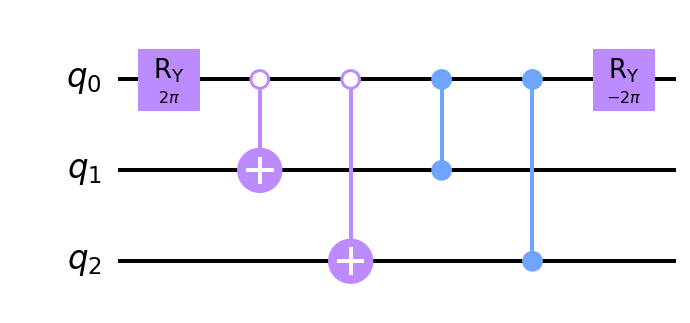

In [3]:
def U_circ(nqubits, theta):
    
    qc = QuantumCircuit(nqubits+1)
    
    qc.ry(2 * theta, 0)
    
    qc.cx(0, 1, ctrl_state='0')
    qc.cx(0, 2, ctrl_state='0')
    qc.cz(0, 1)
    qc.cz(0, 2)
    
    qc.ry(-2 * theta, 0)
    
    return qc

U_circ(2, np.pi).draw('mpl', scale=2.0)

#### $U_{\phi}$ circuit

In [4]:
phi = [-0.27237279, -1.8808697, 2.19755533, -0.860515,
0.84659086, 0.62794236, -0.69688032, -0.62874403,
0.7406656, 0.44483992, -0.60489363, -0.60489363,
0.44483992, 0.7406656, -0.62874403, -0.69688032, 
0.62794236, 0.84659086, -0.860515, -0.94403733,
1.26072295, 1.29842354]

#transforming from W-convention to O-convention

phi[0] = phi[0] - np.pi/4
phi[-1] = phi[-1] + np.pi/4 


def U_phi(nqubits, theta):
    
    qc = QuantumCircuit(nqubits+2)
    
    qc.h(0)
    for i in range(len(phi), 0, -1):
        
        qc.cx(1, 0, ctrl_state='0')
        qc.rz(2 * phi[i-1], 0)
        qc.cx(1, 0, ctrl_state='0')
        qc.z(0)
        qc.barrier()
        
        #apply U
        qc.append(U_circ(nqubits, theta), [1]+list(range(2, 2+nqubits)))
        qc.barrier()
    qc.h(0)
        
    return qc

Let's assume we can prepare $\lvert b \rangle$ using an unitary $Q$ i.e. $Q \lvert 0 \rangle = \lvert b \rangle$. As

$U_{\phi}= \begin{bmatrix}
\alpha^{-1} 0.5\kappa^{-1} A^{-1} & \ast \\
\ast & \ast \end{bmatrix}$, then 

$$U_{\phi}(I \otimes Q) \lvert 0 \rangle \otimes \lvert 0 \rangle = 
\lvert 0 \rangle \otimes \alpha^{-1} 0.5\kappa^{-1} A^{-1} \lvert b \rangle + \lvert 1 \rangle \otimes \lvert \psi \rangle.$$ 

This means, the state left after measuring zero on the first qubit is
$ \alpha^{-1} 0.5\kappa^{-1} A^{-1} \lvert b \rangle $, where $0.5\kappa$ is a normalization factor included
during QSVT (see paper).

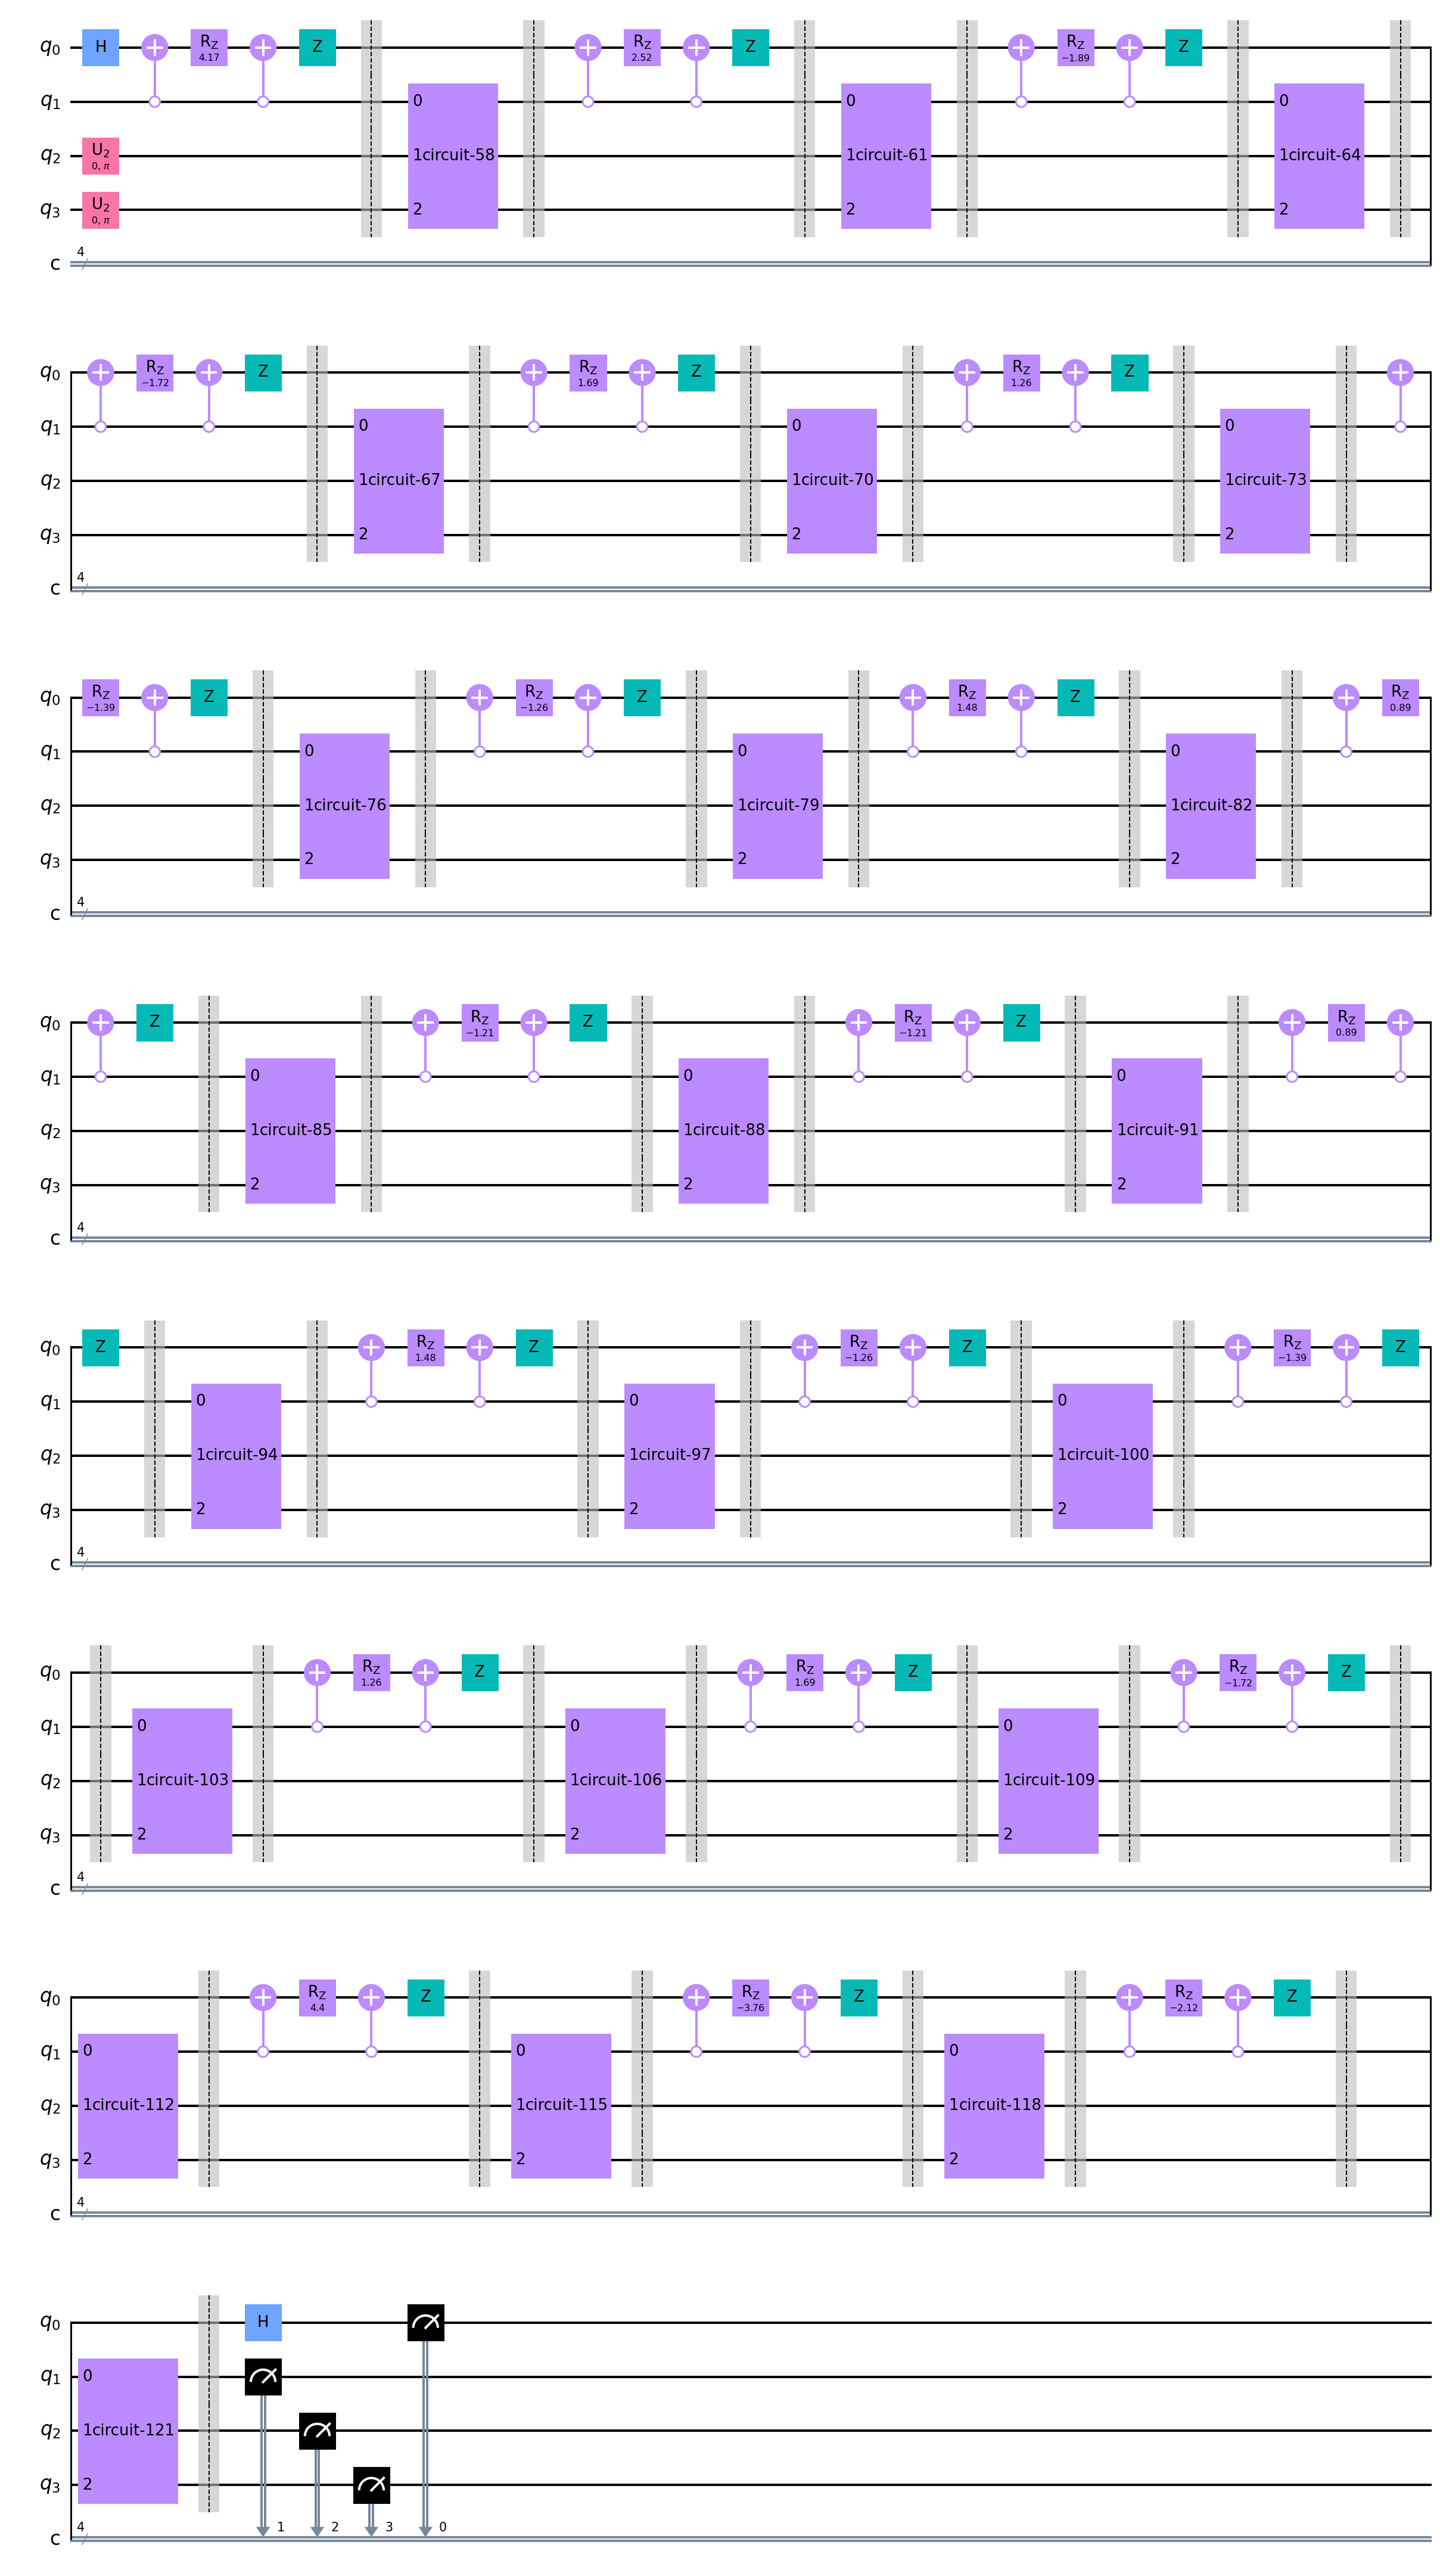

In [5]:
nqubits = 2
kappa = 3
epsilon = 0.3

c0 = 0.4
c1 = 0.6

alpha = 1/np.sqrt(c0 + c1)
theta = np.cos(np.sqrt(c0) * alpha)

qc = QuantumCircuit(nqubits+2, nqubits+2)

#apply Q
qc.h(2)
qc.h(3)

qc.append(U_phi(nqubits=2, theta=theta), [0, 1, 2, 3])

#measure second qubit
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])

qc.decompose().draw('mpl', scale=2.0)

In [6]:
from qiskit import Aer, transpile

simulator = Aer.get_backend('aer_simulator')
qc = transpile(qc, simulator)

# Run and get counts
result = simulator.run(qc).result()
counts = result.get_counts(qc)

counts

{'1001': 2,
 '0101': 2,
 '1011': 13,
 '0000': 8,
 '1101': 241,
 '0111': 16,
 '1010': 119,
 '1100': 10,
 '0100': 138,
 '0110': 138,
 '0001': 236,
 '1000': 101}

In [7]:
p = {'00':0, '01':0, '10':0, '11':0}

tot_count_00 = 0
tot_count = 0
for state, count in counts.items():
    tot_count += count
    if state[2:] == '00':
        p[state[0:2]] = count
        tot_count_00 += count

for key, val in p.items():
    p[key] = np.sqrt(p[key]/tot_count_00)
    
x_calc = np.zeros(4)
x_calc[0] = p['00']
x_calc[1] = p['10']
x_calc[2] = p['01']
x_calc[3] = p['11']

norm_x_calc = np.sqrt(tot_count_00/tot_count)

In [8]:
Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
kappa = 3.0

A_0 = np.kron(X, X)

A_1 = np.kron(Z, Z)

A_num = c0 * A_0 + c1 * A_1

b = np.ones(4) / 2

print(np.linalg.eig(A_num))
A_inv = np.linalg.inv(A_num)

x_actual = np.dot(A_inv, b)

(array([ 1. ,  0.2, -0.2, -1. ]), array([[ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.70710678, -0.70710678],
       [ 0.        ,  0.        ,  0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678,  0.        ,  0.        ]]))


#### Compare norms

In [9]:
print(norm_x_calc * kappa * alpha * 2, np.linalg.norm(x_actual))

4.168369043255315 3.6055512754639905


## W convention

/opt/anaconda3/envs/qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


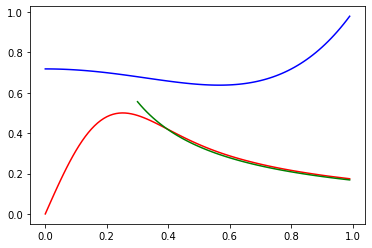

In [16]:
phi = [-0.27237279, -1.8808697, 2.19755533, -0.860515,
0.84659086, 0.62794236, -0.69688032, -0.62874403,
0.7406656, 0.44483992, -0.60489363, -0.60489363,
0.44483992, 0.7406656, -0.62874403, -0.69688032, 
0.62794236, 0.84659086, -0.860515, -0.94403733,
1.26072295, 1.29842354]


kappa = 3.0

def W(x): 

    return np.matrix([[x, 1j * np.sqrt(1 - x**2)],
                   [1j * np.sqrt(1 - x**2), x]])

def rZ(theta):
    
    return np.matrix([[np.exp(-1j * theta), 0],
                   [0, np.exp(1j * theta)]])

def end_m(x):
    
    ans = rZ(phi[0]) 
    for i in range(1, len(phi)):
        ans *= W(x) * rZ(phi[i])

    return ans

def end_m_trunc(x, end=5):
    
    ans = rZ(phi[0]) 
    for i in range(1, end):
        ans *= W(x) * rZ(phi[i])

    return ans

px = []
for i in np.arange(0,1,0.01):
    px.append(0.5 * (end_m(i)[0,0] 
                     + np.conjugate(end_m(i))[0,0])) #real part
    
px_trunc = []
for i in np.arange(0,1,0.01):
    px_trunc.append(0.5 * (end_m_trunc(i)[0,0] 
                     + np.conjugate(end_m_trunc(i))[0,0])) #real part
    
plt.plot(np.arange(0,1,0.01), px, 'r')
plt.plot(np.arange(0,1,0.01), px_trunc, 'b')
plt.plot(np.arange(0.3,1,0.01), [1/x/2/kappa for x in np.arange(0.3, 1, 0.01)], 'g')

## O-convention

/opt/anaconda3/envs/qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


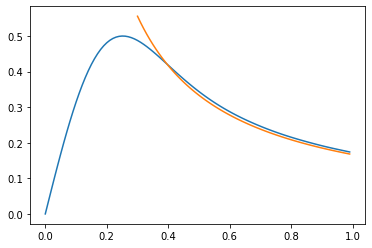

In [11]:
phi = [-0.27237279, -1.8808697, 2.19755533, -0.860515,
0.84659086, 0.62794236, -0.69688032, -0.62874403,
0.7406656, 0.44483992, -0.60489363, -0.60489363,
0.44483992, 0.7406656, -0.62874403, -0.69688032, 
0.62794236, 0.84659086, -0.860515, -0.94403733,
1.26072295, 1.29842354]

#we transfrom from W to O convention
#for i in range(1, len(phi)-1):
#    phi[i] = (phi[i] + np.pi/2.0)
    
phi[0] = phi[0] - np.pi/4
phi[-1] = phi[-1] + np.pi/4 

kappa = 3.0

def W(x): 

    return np.matrix([[x, -np.sqrt(1 - x**2)],
                   [np.sqrt(1 - x**2), x]])

def rZ(theta):
    
    return np.matrix([[np.exp(-1j * theta), 0],
                   [0, np.exp(1j * theta)]])

def end_m(x):
    
    ans = rZ(phi[0]) 
    for i in range(1, len(phi)):
        ans *= W(x) * rZ(phi[i])

    return ans

px = []
for i in np.arange(0,1,0.01):
    px.append(0.5 * (end_m(i)[0,0] 
                     + np.conjugate(end_m(i))[0,0])) #real part
    
plt.plot(np.arange(0,1,0.01), px)
plt.plot(np.arange(0.3,1,0.01), [1/x/2/kappa for x in np.arange(0.3, 1, 0.01)])

## Neumann Series

In [145]:
A = np.array([[0.2, 0.1],[0.4, 0.5]])

A = A + A.T
Anorm =  np.max(np.linalg.eigvals(A))
A = A/Anorm/2

print(np.linalg.eigvals(A))

bp = np.ones(2) / np.sqrt(2)

B_num = Id - A

x_sol = Id.dot(bp) 
for i in range(1, 8):
    x_sol += np.linalg.matrix_power(A, i).dot(bp)
    
x_sol

[0.04555578 0.5       ]


array([1.18930547, 1.5329023 ])

In [135]:
x_actual = np.linalg.inv(B_num).dot(bp)
x_actual

array([1.19301501, 1.53945405])

In [127]:
x_sol

array([0.51010101, 0.78779141, 0.78779141, 0.51010101])